In [7]:
import numpy as np
import pandas as pd

In [8]:
!ls ../input

disasters-on-social-media  glove6b50d


In [9]:
import codecs
input_file = codecs.open('../input/disasters-on-social-media/socialmedia-disaster-tweets-DFE.csv', 
                         'r',
                         encoding='utf-8', 
                         errors='replace')
output_file = open('clean_socialmedia-disaster.csv', 'w')
    
for line in input_file:
    out = line
    output_file.write(line)


In [10]:
input_file.close()

In [11]:
output_file.close()

In [12]:
df = pd.read_csv('clean_socialmedia-disaster.csv')

In [13]:
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN


In [14]:
df.shape

(10876, 13)

In [15]:
df.choose_one.unique()

array(['Relevant', 'Not Relevant', "Can't Decide"], dtype=object)

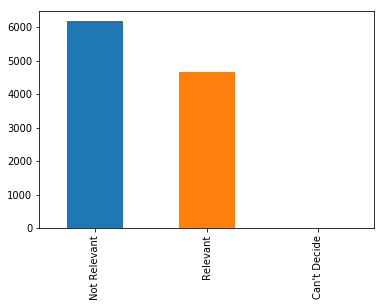

In [16]:
df['choose_one'].value_counts().plot(kind='bar')

In [17]:
df = df[df.choose_one != "Can't Decide"]

In [18]:
df.shape

(10860, 13)

In [19]:
df = df[['text','choose_one']]

In [20]:
df.head()

,text,choose_one
0,Just happened a terrible car crash,Relevant
1,Our Deeds are the Reason of this #earthquake M...,Relevant
2,"Heard about #earthquake is different cities, s...",Relevant
3,"there is a forest fire at spot pond, geese are...",Relevant
4,Forest fire near La Ronge Sask. Canada,Relevant


In [21]:
df['relevant'] = df.choose_one.map({'Relevant':1,'Not Relevant':0})

In [22]:
df.head()

,text,choose_one,relevant
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [23]:
df.describe()

,relevant
count,10860.000000
mean,0.430295
std,0.495140
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# Lemmatization

In [24]:
import spacy

In [25]:
nlp = spacy.load('en',disable=['tagger','parser','ner'])

In [26]:
from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)

In [27]:
df['lemmas'] = df["text"].progress_apply(lambda row: 
                                         [w.lemma_ for w in nlp(row)])

100%|██████████| 10860/10860 [00:09<00:00, 1163.72it/s]


In [28]:
df.head()

,text,choose_one,relevant,lemmas
0,Just happened a terrible car crash,Relevant,1,"[Just, happen, a, terrible, car, crash]"
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1,"[Our, Deeds, be, the, Reason, of, this, #, ear..."
2,"Heard about #earthquake is different cities, s...",Relevant,1,"[Heard, about, #, earthquake, be, different, c..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, be, a, forest, fire, at, spot, pond, ,..."
4,Forest fire near La Ronge Sask. Canada,Relevant,1,"[Forest, fire, near, La, Ronge, Sask, ., Canada]"


In [29]:
df['joint_lemmas'] = df['lemmas'].progress_apply(lambda row: ' '.join(row))

100%|██████████| 10860/10860 [00:00<00:00, 404261.30it/s]


In [30]:
df.head()

,text,choose_one,relevant,lemmas,joint_lemmas
0,Just happened a terrible car crash,Relevant,1,"[Just, happen, a, terrible, car, crash]",Just happen a terrible car crash
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1,"[Our, Deeds, be, the, Reason, of, this, #, ear...",Our Deeds be the Reason of this # earthquake M...
2,"Heard about #earthquake is different cities, s...",Relevant,1,"[Heard, about, #, earthquake, be, different, c...","Heard about # earthquake be different city , s..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, be, a, forest, fire, at, spot, pond, ,...","there be a forest fire at spot pond , goose be..."
4,Forest fire near La Ronge Sask. Canada,Relevant,1,"[Forest, fire, near, La, Ronge, Sask, ., Canada]",Forest fire near La Ronge Sask . Canada


# Bag of words

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['joint_lemmas'], 
                                                    df['relevant'], 
                                                    test_size=0.2,
                                                    random_state=40)

In [32]:

from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_features=5000)
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [33]:
X_train_counts.shape

(8688, 5000)

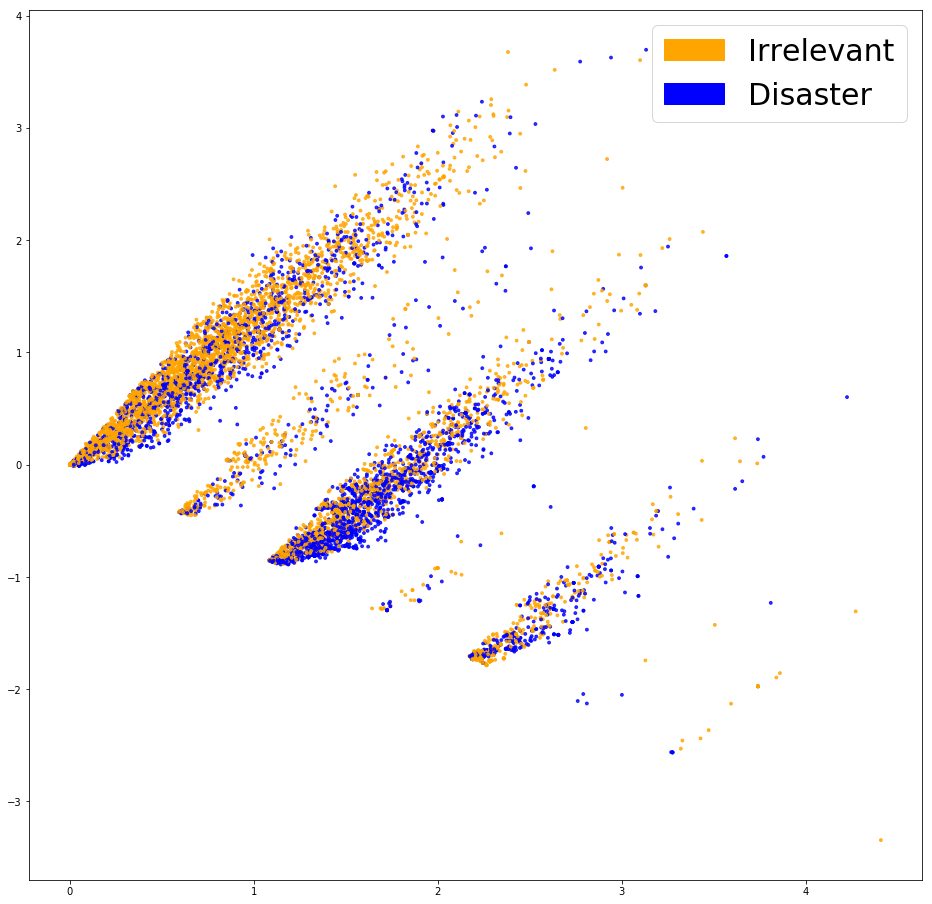

In [34]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib

 

lsa = TruncatedSVD(n_components=2)
lsa.fit(X_train_counts)
lsa_scores = lsa.transform(X_train_counts)


fig = plt.figure(figsize=(16, 16))   
colors = ['orange','blue']

plt.scatter(lsa_scores[:,0], 
            lsa_scores[:,1], 
            s=8, alpha=.8, 
            c=y_train,
            cmap=matplotlib.colors.ListedColormap(colors))

ir_patch = mpatches.Patch(color='Orange',label='Irrelevant')

dis_patch = mpatches.Patch(color='Blue',label='Disaster')

plt.legend(handles=[ir_patch, dis_patch], prop={'size': 30})

plt.show()

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression()

clf.fit(X_train_counts, y_train)

y_predicted = clf.predict(X_test_counts)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [36]:
accuracy_score(y_test, y_predicted)

0.8011049723756906

In [37]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

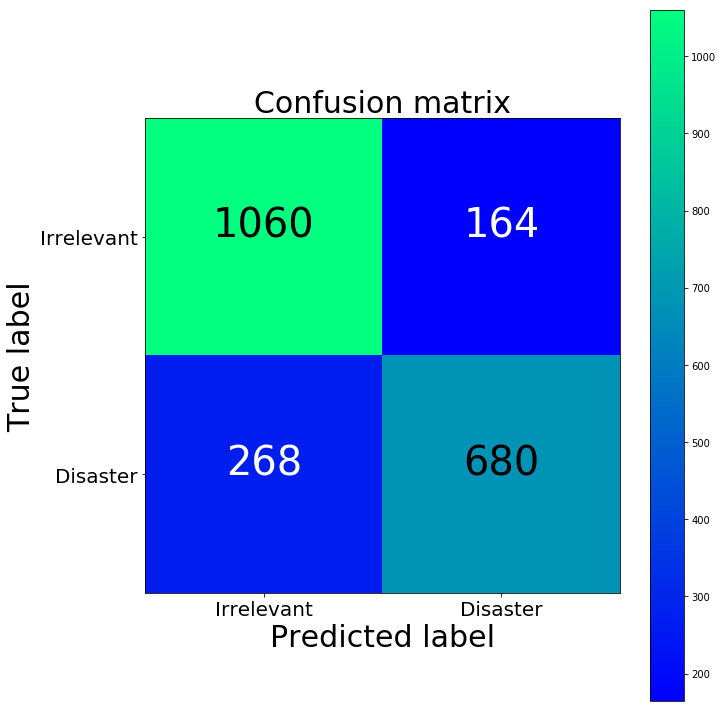

[[1060  164]
 [ 268  680]]


In [38]:
cm = confusion_matrix(y_test, y_predicted)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)


In [39]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

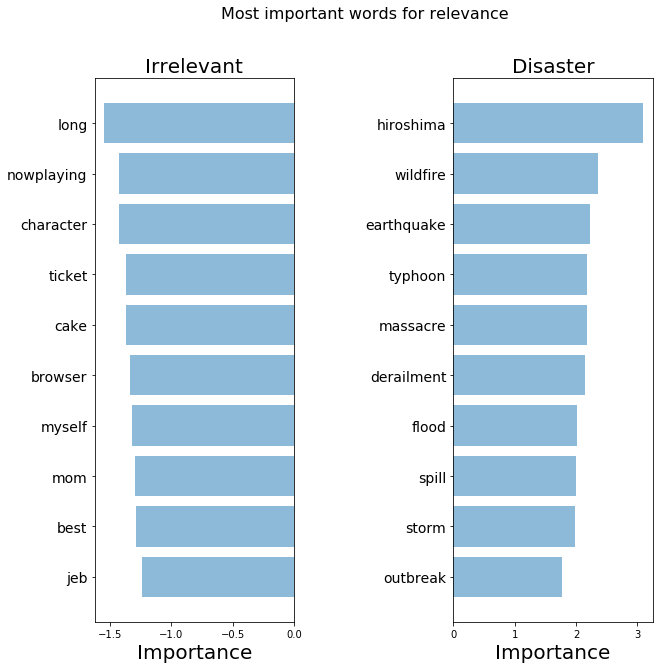

In [40]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

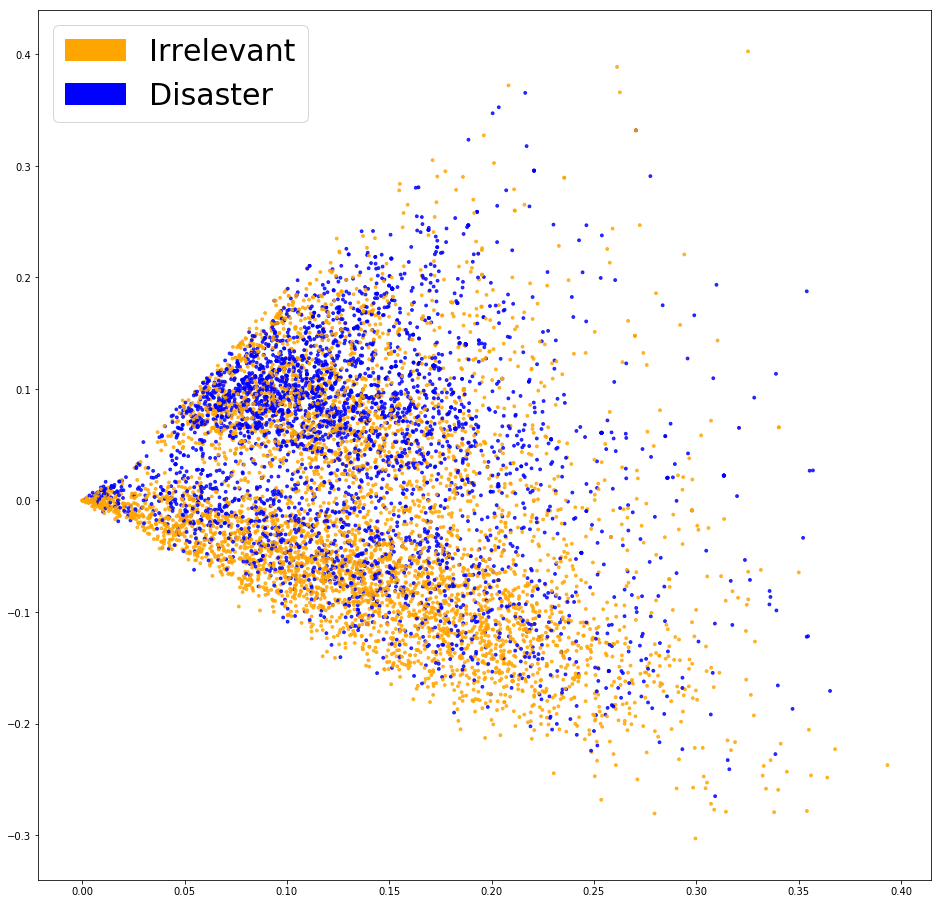

In [42]:
lsa = TruncatedSVD(n_components=2)
lsa.fit(X_train_tfidf)
lsa_scores = lsa.transform(X_train_tfidf)

fig = plt.figure(figsize=(16, 16))          
colors = ['orange','blue']

plt.scatter(lsa_scores[:,0], 
            lsa_scores[:,1], 
            s=8, alpha=.8, 
            c=y_train,
            cmap=matplotlib.colors.ListedColormap(colors))

ir_patch = mpatches.Patch(color='Orange',label='Irrelevant')

dis_patch = mpatches.Patch(color='Blue',label='Disaster')

plt.legend(handles=[ir_patch, dis_patch], prop={'size': 30})
plt.show()

In [43]:
clf_tfidf = LogisticRegression()
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [44]:
accuracy_score(y_pred=y_predicted_tfidf, y_true=y_test)

0.7978821362799263

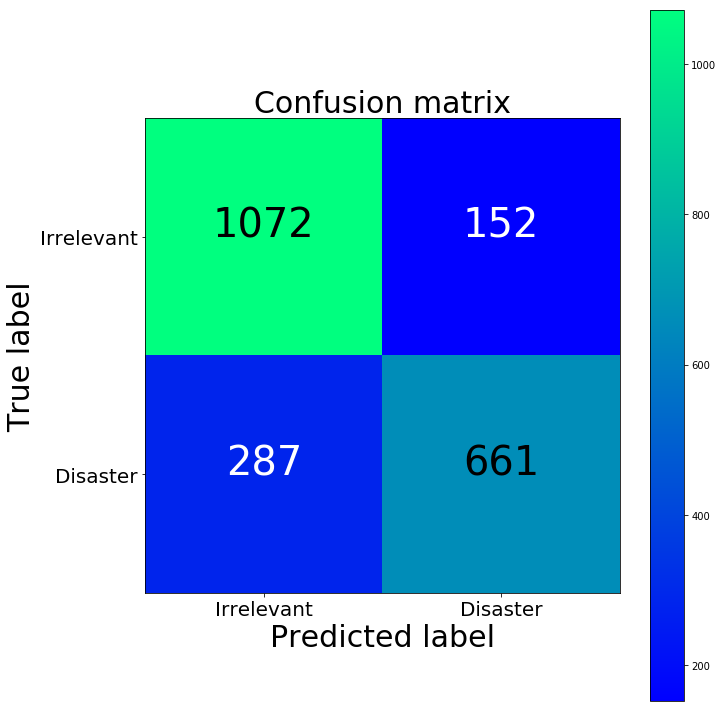

TFIDF confusion matrix
[[1072  152]
 [ 287  661]]
BoW confusion matrix
[[1060  164]
 [ 268  680]]


In [45]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [46]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

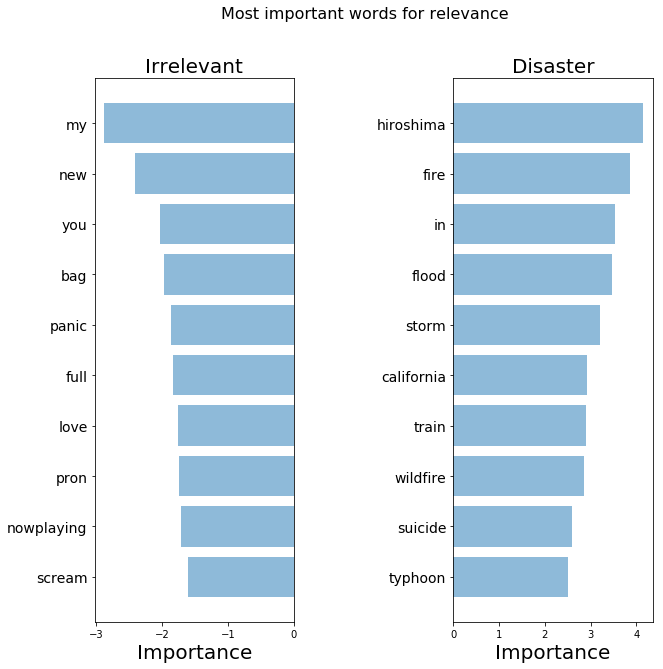

In [47]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# Word vectors

In [48]:
from keras.preprocessing.text import Tokenizer
import numpy as np

max_words = 10000 # We will only consider the 10K most used words in this dataset

Using TensorFlow backend.


In [49]:
tokenizer = Tokenizer(num_words=max_words) # Setup
tokenizer.fit_on_texts(df['joint_lemmas']) # Generate tokens by counting frequency
sequences = tokenizer.texts_to_sequences(df['joint_lemmas']) # Turn text into sequence of numbers

In [50]:
word_index = tokenizer.word_index
print('Token for "the"',word_index['the'])
print('Token for "Movie"',word_index['movie'])

Token for "the" 4
Token for "Movie" 333


In [51]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 140 # Make all sequences 140 words long
data = pad_sequences(sequences, maxlen=maxlen)
print(data.shape) # We have 25K, 140 word sequences now

(10860, 140)


In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    df['relevant'],
                                                    test_size = 0.2, 
                                                    shuffle=True, 
                                                    random_state = 42)

## Training custom word vectors

In [53]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

embedding_dim = 50

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
#model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 50)           500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 7000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7001      
Total params: 507,001
Trainable params: 507,001
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [55]:
type(data)

numpy.ndarray

In [56]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 8688 samples, validate on 2172 samples
Epoch 1/10
8688/8688 [==============================] - 8s 958us/step - loss: 0.5866 - acc: 0.6929 - val_loss: 0.4928 - val_acc: 0.7703
Epoch 2/10
8688/8688 [==============================] - 1s 99us/step - loss: 0.3842 - acc: 0.8456 - val_loss: 0.4593 - val_acc: 0.8016
Epoch 3/10
8688/8688 [==============================] - 1s 100us/step - loss: 0.2727 - acc: 0.8943 - val_loss: 0.4745 - val_acc: 0.7924
Epoch 4/10
8688/8688 [==============================] - 1s 97us/step - loss: 0.1925 - acc: 0.9346 - val_loss: 0.5092 - val_acc: 0.7878
Epoch 5/10
8688/8688 [==============================] - 1s 98us/step - loss: 0.1359 - acc: 0.9583 - val_loss: 0.5569 - val_acc: 0.7781
Epoch 6/10
8688/8688 [==============================] - 1s 98us/step - loss: 0.1023 - acc: 0.9702 - val_loss: 0.5881 - val_acc: 0.7758
Epoch 7/10
8688/8688 [==============================] - 1s 99us/step - loss: 0.0801 - acc: 0

In [57]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

embedding_dim = 50

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 140, 50)           500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 510,657
Trainable params: 510,657
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [59]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Train on 8688 samples, validate on 2172 samples
Epoch 1/10
8688/8688 [==============================] - 58s 7ms/step - loss: 0.5273 - acc: 0.7315 - val_loss: 0.4656 - val_acc: 0.7891
Epoch 2/10
8688/8688 [==============================] - 57s 7ms/step - loss: 0.3380 - acc: 0.8606 - val_loss: 0.4773 - val_acc: 0.7864
Epoch 3/10
8688/8688 [==============================] - 57s 7ms/step - loss: 0.2584 - acc: 0.8992 - val_loss: 0.5584 - val_acc: 0.7808
Epoch 4/10
8688/8688 [==============================] - 56s 6ms/step - loss: 0.2075 - acc: 0.9232 - val_loss: 0.6188 - val_acc: 0.7799
Epoch 5/10
8688/8688 [==============================] - 57s 7ms/step - loss: 0.1720 - acc: 0.9388 - val_loss: 0.6440 - val_acc: 0.7712
Epoch 6/10
8688/8688 [==============================] - 54s 6ms/step - loss: 0.1406 - acc: 0.9497 - val_loss: 0.8097 - val_acc: 0.7491
Epoch 7/10
8688/8688 [==============================] - 55s 6ms/step - loss: 0.1159 - acc: 0.9598 - val_loss: 0.8202 - val_acc: 0.7583
Epoch 8

In [61]:
y_predicted_nn = model.predict_classes(X_test)
accuracy_score(y_pred=y_predicted_nn, y_true=y_test)

0.753683241252302

## Using pre trained word vectors

In [ ]:
!ls ../input/glove6b50d

In [ ]:
import os
glove_dir = '../input/glove6b50d' # This is the folder with the dataset

embeddings_index = {} # We create a dictionary of word -> embedding
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt')) # Open file

# In the dataset, each line represents a new word embedding
# The line starts with the word and the embedding values follow
for line in f:
    values = line.split()
    word = values[0] # The first value is the word, the rest are the values of the embedding
    embedding = np.asarray(values[1:], dtype='float32') # Load embedding
    embeddings_index[word] = embedding # Add embedding to our embedding dictionary
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean = all_embs.mean() # Calculate mean
emb_std = all_embs.std() # Calculate standard deviation
emb_mean,emb_std

In [ ]:
embedding_dim = 50

word_index = tokenizer.word_index
nb_words = min(max_words, len(word_index)) # How many words are there actually

# Create a random matrix with the same mean and std as the embeddings
embedding_matrix = np.random.normal(emb_mean, 
                                    emb_std, 
                                    (nb_words, embedding_dim))

# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= max_words: 
        continue
    # Get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, 
                    embedding_dim, 
                    input_length=maxlen, 
                    weights = [embedding_matrix], trainable = False))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

In [ ]:
y_predicted_nn = model.predict_classes(X_test)
accuracy_score(y_pred=y_predicted_nn, y_true=y_test)

In [ ]:
from keras.layers import CuDNNLSTM
model = Sequential()
model.add(Embedding(max_words, 
                    embedding_dim, 
                    input_length=maxlen, 
                    weights = [embedding_matrix], trainable = False))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

In [ ]:
y_predicted_nn = model.predict_classes(X_test)
accuracy_score(y_pred=y_predicted_nn, y_true=y_test)

In [ ]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(max_words, 
                    embedding_dim, 
                    input_length=maxlen, 
                    weights = [embedding_matrix], trainable = False))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

In [ ]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(max_words, 
                    embedding_dim, 
                    input_length=maxlen, 
                    weights = [embedding_matrix], trainable = False))
model.add(Bidirectional(CuDNNLSTM(64,return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(64,return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(64,return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(32)))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

# Attention

In [ ]:
from keras.layers import Multiply, CuDNNLSTM, Permute, Reshape, Dense, Lambda, Input, Embedding, RepeatVector
import keras.backend as K
from keras.layers import LSTM
from keras.models import Model

In [ ]:
INPUT_DIM = embedding_dim
TIME_STEPS = maxlen
SINGLE_ATTENTION_VECTOR = False

In [ ]:
from keras.layers import *
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

In [ ]:
def attention_3d_block(inputs,time_steps,single_attention_vector = False):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1),name='Attent_Permute')(inputs)
    a = Reshape((input_dim, time_steps),name='Reshape')(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(time_steps, activation='softmax', name='Attent_Dense')(a) # Create attention vector
    if single_attention_vector:
        # If we just need one attention vector it over all input dimensions
        a = Lambda(lambda x: K.mean(x, axis=1), name='Dim_reduction')(a) 
        a = RepeatVector(input_dim, name='Repeat')(a)
    a_probs = Permute((2, 1), name='Attention_vec')(a) # Swap time steps, input dim axis back
    output_attention_mul = Multiply(name='Attention_mul')([inputs, a_probs]) # Multiply input with attention vector
    return output_attention_mul

In [ ]:
input_tokens = Input(shape=(maxlen,),name='input')

embedding = Embedding(max_words, 
                      embedding_dim, 
                      input_length=maxlen, 
                      weights = [embedding_matrix], 
                      trainable = False, name='embedding')(input_tokens)

attention_mul = attention_3d_block(inputs = embedding,
                                   time_steps = maxlen,
                                   single_attention_vector = True)

lstm_out = CuDNNLSTM(32, return_sequences=True, name='lstm')(attention_mul)



attention_mul = Flatten(name='flatten')(attention_mul)
output = Dense(1, activation='sigmoid',name='output')(attention_mul)
model = Model(input_tokens, output)


In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

# Similarity

In [ ]:
nlp = spacy.load('en')

In [ ]:
sup1 = nlp('I would like to open a new checking account')
sup2 = nlp('How do I open a checking account?')

In [ ]:
sup1.similarity(sup2)

In [ ]:
sup3 = nlp('I want to close my checking account')

In [ ]:
sup1.similarity(sup3)

In [ ]:
sup4 = nlp('I like checking the news')

In [ ]:
sup1.similarity(sup4)

In [ ]:
import sense2vec

In [ ]:
def attention_3d_block(inputs,maxlen,single_attention_vector = False):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    time_steps = int(inputs.shape[1])
    #print(input_dim,time_steps)
    a = Permute((2, 1))(inputs) # Swap axis 1 & 2
    a = Reshape((input_dim, maxlen))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(maxlen, activation='softmax')(a) # Create dense layer to apply to input
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply(name='attention_mul')([inputs, a_probs])
    return output_attention_mul